In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/drive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/drive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/drive/MyDrive/ece5545
%cd /content/drive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/drive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/drive/MyDrive/ece5545

PROJECT_ROOT = f"/content/drive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/drive/MyDrive/ece5545’: File exists
/content/drive/MyDrive/ece5545
fatal: destination path 'a4-NamanMakkar' already exists and is not an empty directory.
/content/drive/MyDrive/ece5545/a4-NamanMakkar
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 365 bytes | 12.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a4-NamanMakkar
   ca9233d..4058c65  main       -> origin/main
Updating ca9233d..4058c65
Fast-forward
 src/extra_credit_logmatmul.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)
/content/drive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

In [5]:
!ls {PROJECT_ROOT}

1-numerical_precision.ipynb
2-svd_rank.ipynb
data
errors_plot.png
fft_reconstruction_loss.png
mnist.py
ranks_vs_flops_runtime_speedup.png
rank_vs_flops.png
rank_vs_flops_speedup.png
rank_vs_runtime.png
rank_vs_runtime_speedup.png
README.md
reconstruction_error_extra_creidt_logmatmul.png
reconstruction_error_logmatmul.png
src
tests
winograd_reconstruction_loss.png


In [6]:
!pip install torch numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Convolution

In the following cell(s), please plot the reconstruction error of an
approximated tensor (in the y-axis) with the numerical precision
(in the x-axis). Please show one plot for `winograd` and one plot for `fft`.

In [7]:
%cd {PROJECT_ROOT}

/content/drive/MyDrive/ece5545/a4-NamanMakkar


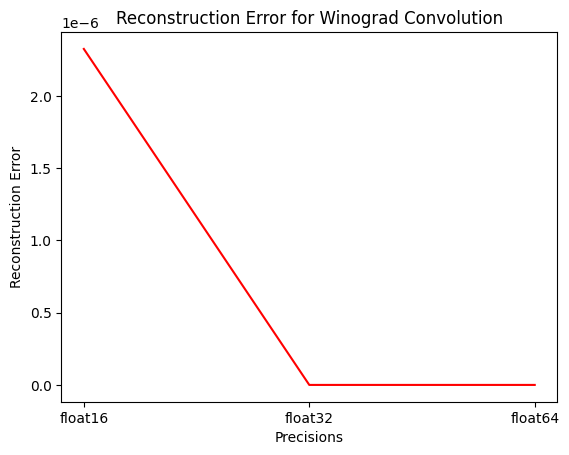

In [8]:
from src.conv2d import winograd, pytorch, fft
from src.matmul import logmatmul
from src.extra_credit_logmatmul import logmatmul_approx, create_lookup_table, log_add_approximation
import torch
import numpy as np
import matplotlib.pyplot as plt
# TODO: plot the error v.s. precision curve
device = 'cuda'
#!python -m pytest tests/test_conv2d.py
def reconstruction_error(true, pred):
  return np.mean((true - pred)**2)

precisions = [torch.float16, torch.float32, torch.float64]
precisions_str = ['float16','float32','float64']
errors_winograd = []
for (idx,precision) in enumerate(precisions):
  input_tensor = torch.rand(size=(43,43),dtype=precision,device=device)
  kernel = torch.rand(size=(3,3),dtype=precision,device=device)
  bias = torch.tensor([0.1], dtype=precision, device=device)
  winograd_conv_output = winograd(input_tensor, kernel, bias).cpu().numpy()
  pytorch_conv_output = pytorch(input_tensor, kernel, bias).cpu().numpy()
  error = reconstruction_error(pytorch_conv_output, winograd_conv_output)
  errors_winograd.append(error)
  torch.cuda.empty_cache()

fig = plt.figure()
plt.title('Reconstruction Error for Winograd Convolution')
plt.plot(precisions_str, errors_winograd, 'r')
plt.xlabel('Precisions')
plt.ylabel('Reconstruction Error')
fig.savefig('winograd_reconstruction_loss.png')
plt.show()

/content/drive/MyDrive/ece5545/a4-NamanMakkar/src/conv2d.py:119: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  x_fft = torch.fft.fft2(x_padded)


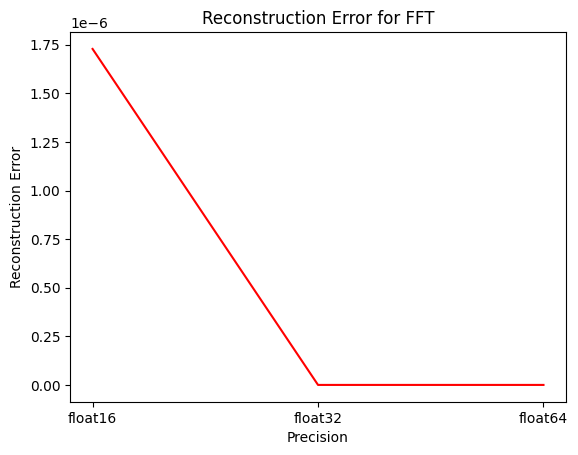

In [9]:
from src.conv2d import fft
# TODO: plot the error v.s. precision curve
precisions = [torch.float16, torch.float32, torch.float64]
precisions_str = ['float16', 'float32', 'float64']
errors_fft = []
for precision in precisions:
  input_tensor = torch.rand(size=(31,31),dtype=precision,device=device)
  kernel = torch.rand(size=(2,2),dtype=precision,device=device)
  bias = torch.tensor([0.1], dtype=precision, device=device)
  fft_output = fft(input_tensor, kernel, bias).cpu().numpy()
  pytorch_conv_output = pytorch(input_tensor, kernel, bias).cpu().numpy()
  error = reconstruction_error(pytorch_conv_output, fft_output)
  errors_fft.append(error)
  torch.cuda.empty_cache()

fig = plt.figure()
plt.title('Reconstruction Error for FFT')
plt.plot(precisions_str, errors_fft, 'r')
plt.xlabel('Precision')
plt.ylabel('Reconstruction Error')
plt.show()
fig.savefig('fft_reconstruction_loss.png')

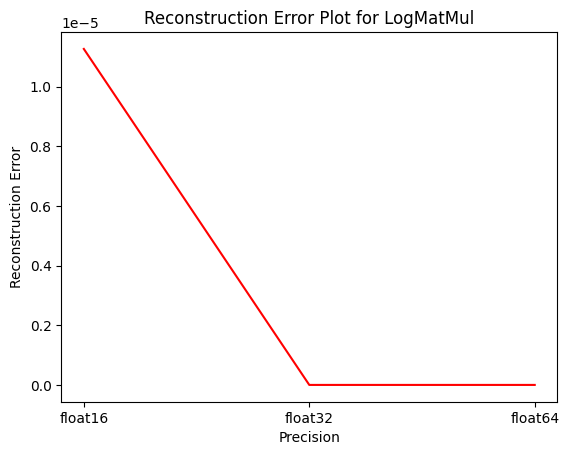

In [10]:
from src.matmul import logmatmul

# TODO: plot the error v.s. precision curve
precisions = [torch.float16, torch.float32, torch.float64]
precisions_str = ['float16', 'float32', 'float64']
errors_logmatmul_reconstruction = []
for precision in precisions:
  A = torch.rand(size=(100,80),dtype=precision, device=device)
  B = torch.rand(size=(80,100),dtype=precision, device=device)
  naive_result = (A.matmul(B)).cpu().numpy()
  logmatmul_result = logmatmul(A,B).cpu().numpy()
  error = reconstruction_error(naive_result, logmatmul_result)
  errors_logmatmul_reconstruction.append(error)
  torch.cuda.empty_cache()


fig = plt.figure()
plt.title('Reconstruction Error Plot for LogMatMul')
plt.plot(precisions_str, errors_logmatmul_reconstruction, 'r')
plt.xlabel('Precision')
plt.ylabel("Reconstruction Error")
plt.show()
fig.savefig('reconstruction_error_logmatmul.png')

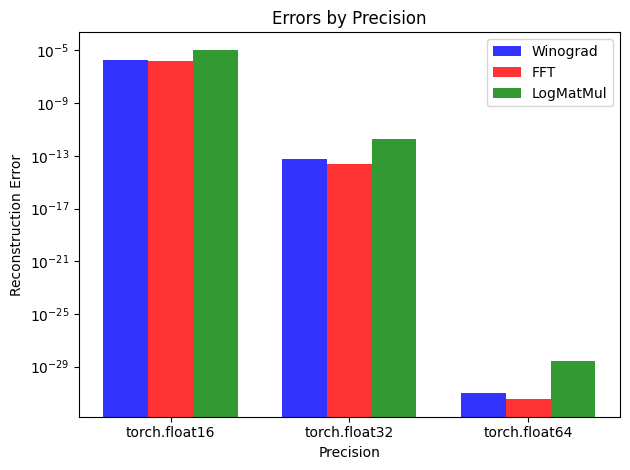

In [11]:
bar_width = 0.25
opacity = 0.8

index = np.arange(len(precisions_str))

plt.bar(index, errors_winograd, bar_width, alpha=opacity, color='b', label='Winograd')
plt.bar(index + bar_width, errors_fft, bar_width, alpha=opacity, color='r', label='FFT')
plt.bar(index + 2 * bar_width, errors_logmatmul_reconstruction, bar_width, alpha=opacity, color='g', label='LogMatMul')

plt.xlabel('Precision')
plt.ylabel('Reconstruction Error')
plt.title('Errors by Precision')
plt.xticks(index + bar_width, precisions)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig('errors_plot.png', dpi=300, bbox_inches='tight')
plt.show()

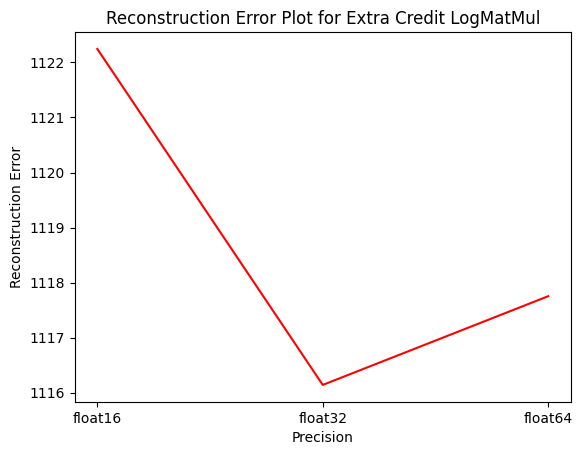

In [13]:
# TODO: plot the error v.s. precision curve for logmatmul extra credit
precisions = [torch.float16, torch.float32, torch.float64]
precisions_str = ['float16', 'float32', 'float64']
errors_logmatmul_reconstruction = []
lookup_table_sizes = [512,1024,2048]
for (idx,precision) in enumerate(precisions):
  A = torch.rand(size=(100,80),dtype=precision, device=device)
  B = torch.rand(size=(80,100),dtype=precision, device=device)
  naive_result = (A.matmul(B)).cpu().numpy()
  logmatmul_result = logmatmul_approx(A, B, 40960, device).cpu().numpy()
  error = reconstruction_error(naive_result, logmatmul_result)
  errors_logmatmul_reconstruction.append(error)
  torch.cuda.empty_cache()


fig = plt.figure()
plt.title('Reconstruction Error Plot for Extra Credit LogMatMul')
plt.plot(precisions_str, errors_logmatmul_reconstruction, 'r')
plt.xlabel('Precision')
plt.ylabel("Reconstruction Error")
plt.show()
fig.savefig('reconstruction_error_extra_creidt_logmatmul.png')